Notebook for development and testing of code for the second version of fitting latent regression models across multiple subjects with variational inference.  The main advance in version 2.0 of the code is the ability to support distributions across additional model parameters (not just the modes). 

In particular we generate models of how one neural population drives another as follows:

1) The user specified a number of subjects and how many neurons are in each population for each of those subjects. Neuron locations for each subject are than randomly drawn from a uniform distribution on the unit square. 

2) Our models include only neural dynamics (no stimulus input or behavioral output) and we use an identity mapping in 
the low d space

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.datasets import TimeSeriesDataset
from janelia_core.ml.latent_regression.group_maps import GroupLinearTransform, IdentityMap
from janelia_core.ml.latent_regression.subject_models import LatentRegModel, SharedMLatentRegModel
from janelia_core.ml.latent_regression.vi import MultiSubjectVIFitter
from janelia_core.ml.latent_regression.vi import PriorCollection
from janelia_core.ml.latent_regression.vi import SubjectVICollection
from janelia_core.ml.latent_regression.vi import predict_with_truth
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondMatrixHypercubePrior
from janelia_core.ml.torch_distributions import CondMatrixProductDistribution
from janelia_core.ml.torch_distributions import MatrixGaussianProductDistribution
from janelia_core.ml.torch_parameter_penalizers import ScalarPenalizer
from janelia_core.ml.utils import torch_mod_to_fcn
from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.image_generation import generate_dot_image_3d
from janelia_core.visualization.image_visualization import visualize_2d_function


In [3]:
%matplotlib notebook

## Parameters and model specification goes here

In [4]:
# Here we specify the number of subjects (by the length of the list) and number of neurons that will be present
# each population for each subject

n_subj_neurons = [(10000, 10000),
                  (9000, 9000),
                  (11000, 11000)]

# Number of samples of data to generate for each subject
n_smps = 20000

# True if we should used shared posteriors among subjects
use_shared_posts = False 


### Parameters for creating hypercube functions

In [5]:
hc_fcn_params = {'n_divisions_per_dim': [50, 50], 
                 'dim_ranges': np.asarray([[-.1, 1.1], [-.1, 1.1]]), 
                 'n_div_per_hc_side_per_dim': [1, 1]}

### Here we specify the mean and standard deviation functions for the different parameters of the models

#### Specify some helper functions

In [6]:
class exp2d(torch.nn.Module):
    def __init__(self, ctr, std, gain, offset):
        #assert(ctr.shape == [1, 2])
        #assert(std.shape == [1,2])
        
        super().__init__()
        self.ctr = torch.nn.Parameter(ctr)
        self.std = torch.nn.Parameter(std)
        self.gain = torch.nn.Parameter(gain)
        self.offset = torch.nn.Parameter(offset)
        
    def forward(self, x):
        return (self.gain*torch.exp(-1*torch.sum((x - self.ctr)**2/self.std, dim=1)) + self.offset).unsqueeze(1)  

class constantF(torch.nn.Module):
    def __init__(self, vl):
        super().__init__()
        self.vl = vl
        
    def forward(self, x):
        return self.vl*torch.ones([x.shape[0], 1])

#### Specify the distributions over p and u modes

Here we implicitly define the number of modes by the number of distributions we define

In [7]:
p_ctrs = [torch.tensor([.1, .1]), torch.tensor([.9, .9])]
true_p_dists = CondMatrixProductDistribution([CondGaussianDistribution(mn_f=exp2d(ctr = c, 
                                                                                  std = torch.tensor([1.0, 1.0]),
                                                                                  gain = torch.tensor(1.0), 
                                                                                  offset = torch.tensor(0.0)),
                                                                        std_f=constantF(.1)) 
                                              for c in p_ctrs])


 
u_ctrs = [torch.tensor([.1, .1]), torch.tensor([.9, .9])]
true_u_dists = CondMatrixProductDistribution([CondGaussianDistribution(mn_f=exp2d(ctr = c, 
                                                                                  std = torch.tensor([1.0, 1.0]),
                                                                                  gain = torch.tensor(1.0), 
                                                                                  offset = torch.tensor(0.0)),
                                                                        std_f=constantF(.1)) 
                                              for c in u_ctrs])


#### Specify the distributions over scales and offsets and direct connections

In [8]:
true_scale_dist = CondGaussianDistribution(mn_f=exp2d(ctr = torch.tensor([.5, .5]), 
                                                    std = torch.tensor([.5, .5]),
                                                    gain = torch.tensor(10.0), 
                                                    offset = torch.tensor(0.0)),
                                        std_f=constantF(.1))

true_offset_dist = CondGaussianDistribution(mn_f=exp2d(ctr = torch.tensor([.5, .5]), 
                                                    std = torch.tensor([1.0, 1.0]),
                                                    gain = torch.tensor(10.0), 
                                                    offset = torch.tensor(0.0)),
                                        std_f=constantF(.1))

true_psi_dist = CondGaussianDistribution(mn_f=exp2d(ctr = torch.tensor([.5, .5]), 
                                                    std = torch.tensor([6.0, 6.0]),
                                                    gain = torch.tensor(.2), 
                                                    offset = torch.tensor(.1)),
                                        std_f=constantF(.01))

true_direct_map_dist = CondGaussianDistribution(mn_f=exp2d(ctr = torch.tensor([.8, .5]), 
                                                    std = torch.tensor([6.0, 6.0]),
                                                    gain = torch.tensor(.2), 
                                                    offset = torch.tensor(.1)),
                                        std_f=constantF(.01))

## Here we generate our true subject models and data

In [10]:
n_modes = len(true_p_dists.dists)
n_subjs = len(n_subj_neurons)
true_subj_models = [None]*n_subjs
true_data = [None]*n_subjs

for s_i in range(n_subjs):
    
    with torch.no_grad():
        # Generate neuron locations
        p_neuron_locs = torch.rand(size=[n_subj_neurons[s_i][0], 2])
        u_neuron_locs = torch.rand(size=[n_subj_neurons[s_i][1], 2])
    
        # Generate modes
        p_modes = true_p_dists.form_standard_sample(true_p_dists.sample(p_neuron_locs))
        u_modes = true_u_dists.form_standard_sample(true_u_dists.sample(u_neuron_locs))
        
        # Generate scales and offsets
        scales = true_scale_dist.form_standard_sample(true_scale_dist.sample(u_neuron_locs)).squeeze()
        offsets = true_offset_dist.form_standard_sample(true_offset_dist.sample(u_neuron_locs)).squeeze()
        
        # Generate direct maps
        direct_mappings = true_direct_map_dist.form_standard_sample(true_direct_map_dist.sample(u_neuron_locs)).squeeze()
        
        # Generate psi
        psi = true_psi_dist.form_standard_sample(true_psi_dist.sample(u_neuron_locs)).squeeze()
        assert(torch.all(psi > 0))
    
        s_mdl = LatentRegModel(d_in = [n_subj_neurons[s_i][0]], d_out = [n_subj_neurons[s_i][1]], 
                               d_proj=[n_modes], d_trans=[n_modes], 
                               m=IdentityMap(),
                               s=[torch.nn.Identity()], 
                               use_scales=True,
                               use_offsets=True,
                               direct_pairs=[(0,0)], 
                               assign_direct_pair_mappings=True)
    
        s_mdl.u[0].data = u_modes
        s_mdl.p[0].data = p_modes
        s_mdl.offsets[0].data = offsets
        s_mdl.scales[0].data = scales
        s_mdl.psi[0].data = psi
        s_mdl.direct_mappings[0].data = direct_mappings
    
        true_subj_models[s_i] = {'mdl': s_mdl, 'p_neuron_locs': p_neuron_locs, 'u_neuron_locs': u_neuron_locs}
    
        
        p_data = [torch.randn(size=[n_smps, n_subj_neurons[s_i][0]])]
        u_data = s_mdl.generate(p_data)
        
        # Delay u data with respect to u data (since we model u_{t+1} as a function of p_t)
        p_data[0] = p_data[0][1:,:]
        u_data[0] = u_data[0][0:-1, :]
        
        
        
        true_data[s_i] = (p_data, u_data)

## Now we set things up for fitting with variational inference

### Define prior distributions

In [79]:
p_prior = CondMatrixHypercubePrior(n_cols=n_modes, mn_hc_params=hc_fcn_params, std_hc_params=hc_fcn_params, 
                                   min_std=.00001)

u_prior = CondMatrixHypercubePrior(n_cols=n_modes, mn_hc_params=hc_fcn_params, std_hc_params=hc_fcn_params, 
                                   min_std=.00001)

scales_prior = CondMatrixHypercubePrior(n_cols=1, mn_hc_params=hc_fcn_params, std_hc_params=hc_fcn_params, 
                                   min_std=.00001, mn_init=1.0)

offsets_prior = CondMatrixHypercubePrior(n_cols=1, mn_hc_params=hc_fcn_params, std_hc_params=hc_fcn_params, 
                                   min_std=.00001, mn_init=0.0)

direct_mappings_prior = CondMatrixHypercubePrior(n_cols=1, mn_hc_params=hc_fcn_params, std_hc_params=hc_fcn_params, 
                                   min_std=.00001, mn_init=0.0)

prior_collection = PriorCollection(p_dists=[p_prior], u_dists=[u_prior], psi_dists=[None], 
                                   scale_dists=[scales_prior], offset_dists=[offsets_prior], 
                                   direct_mapping_dists=[direct_mappings_prior])

### Define subject models and posteriors for each subject

In [164]:
vi_collections = [None]*n_subjs
for s_i in range(n_subjs):
    
    # Create subject model for fitting
    subject_specific_m = GroupLinearTransform(d=[n_modes], nonnegative_scale=True, 
                                              v_mn=1.0, v_std=.01, o_mn=0.0, o_std=.01)
    s_mdl = SharedMLatentRegModel(d_in = [n_subj_neurons[s_i][0]], d_out = [n_subj_neurons[s_i][1]], 
                                  d_proj=[n_modes], d_trans=[n_modes], specific_m=subject_specific_m,
                                  shared_m=IdentityMap(), s=[torch.nn.Identity()],
                                  use_scales=True, use_offsets=True, direct_pairs=[(0,0)],
                                  assign_p_modes=False, assign_u_modes=False, assign_scales=False, assign_offsets=False,
                                  assign_direct_pair_mappings=False,
                                  assign_psi=True) # We will fit point estimates for psi (and not distributions)    
    
    # Create posterior distributions 
    if use_shared_posts:
        if s_i == 0:
            p_post = CondMatrixHypercubePrior(n_cols=n_modes, mn_hc_params=hc_fcn_params, 
                                              std_hc_params=hc_fcn_params, min_std=.00001, 
                                              mn_init=.1)
            u_post = CondMatrixHypercubePrior(n_cols=n_modes, mn_hc_params=hc_fcn_params, 
                                              std_hc_params=hc_fcn_params, min_std=.00001,
                                              mn_init=.1)
            scale_post = CondMatrixHypercubePrior(n_cols=n_modes, mn_hc_params=hc_fcn_params, 
                                                  std_hc_params=hc_fcn_params, min_std=.00001, 
                                                  mn_init=1.0)
            offset_post = CondMatrixHypercubePrior(n_cols=n_modes, mn_hc_params=hc_fcn_params, 
                                                   std_hc_params=hc_fcn_params, min_std=.00001,
                                                   mn_init=0.0)
            direct_mappings_post = CondMatrixHypercubePrior(n_cols=n_modes, mn_hc_params=hc_fcn_params, 
                                                            std_hc_params=hc_fcn_params, min_std=.00001,
                                                            mn_init=0.0)
        else:
            pass # Do nothing, we can just keep using the posteriors we already created for subject 1
    else:
        p_post = MatrixGaussianProductDistribution(shape=[n_subj_neurons[s_i][0], n_modes], mn_mn=.01, mn_std=.001)
        u_post = MatrixGaussianProductDistribution(shape=[n_subj_neurons[s_i][1], n_modes], mn_mn=.01, mn_std=.001)
        scale_post = MatrixGaussianProductDistribution(shape=[n_subj_neurons[s_i][1], 1], mn_mn=1.0, mn_std=.001)
        offset_post = MatrixGaussianProductDistribution(shape=[n_subj_neurons[s_i][1], 1], mn_mn=0.0, mn_std=.001)
        direct_mappings_post = MatrixGaussianProductDistribution(shape=[n_subj_neurons[s_i][1], 1], mn_mn=0.0, mn_std=.001)
    
    # Package data
    data = TimeSeriesDataset([true_data[s_i][0][0], true_data[s_i][1][0]])[:]
    
    vi_collections[s_i] = SubjectVICollection(s_mdl=s_mdl, p_dists=[p_post], u_dists=[u_post], psi_dists=[None],
                                        scale_dists=[scale_post], 
                                        offset_dists=[offset_post],
                                        direct_mappings_dists=[direct_mappings_post],
                                        data=data, input_grps=[0], output_grps=[1], 
                                        props=[true_subj_models[s_i]['p_neuron_locs'], 
                                               true_subj_models[s_i]['u_neuron_locs']],
                                        p_props = [0], u_props=[1], psi_props=[None], 
                                        scale_props=[1], offset_props=[1], 
                                        direct_mapping_props=[1], min_var=[.0001])

## Generate penalizers

In [165]:
subj_v_params = [coll.s_mdl.specific_m.v[0] for coll in vi_collections]
v_penalizer = ScalarPenalizer(params=subj_v_params, w=10000000.0, init_ctr=1.0, learnable_parameters=False, 
                              description='m scales')
subj_o_params = [coll.s_mdl.specific_m.o[0] for coll in vi_collections]
o_penalizer = ScalarPenalizer(params=subj_o_params, w=10000000.0, init_ctr=0.0, learnable_parameters=False, 
                              description='m offsets')

## Create the fitter 

In [168]:
fitter = MultiSubjectVIFitter(s_collections=vi_collections, prior_collection=prior_collection,
                              penalizers=[v_penalizer, o_penalizer])

## Fit the model

In [169]:
devices, _ = list_torch_devices()

Found 1 GPUs


In [170]:
fitter.distribute(devices, distribute_data=True)

In [171]:
logs0 = fitter.fit(n_epochs=1000, n_batches=2, update_int=10, learning_rates=[(0, .1, {'fast': 1})], 
                  enforce_priors=(use_shared_posts==False))
logs1 = fitter.fit(n_epochs=1000, n_batches=2, update_int=10, learning_rates=.01, 
                  enforce_priors=(use_shared_posts==False))

*****************************************************
Epoch 0 complete.  Obj: 5.33e+14, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 1.77e+14, s_1: 1.44e+14, s_2: 2.12e+14
Subj P KLs:  s_0: 2.11e+05, s_1: 1.91e+05, s_2: 2.30e+05
Subj U KLs:  s_0: 1.84e+05, s_1: 1.67e+05, s_2: 1.98e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 4.16e+05, s_1: 3.70e+05, s_2: 4.58e+05
Subj Offsets KLs:  s_0: 3.04e+07, s_1: 2.71e+07, s_2: 3.32e+07
Subj Direct Mappings KLs:  s_0: 1.28e+06, s_1: 1.08e+06, s_2: 1.45e+06
Penalties:  o_0: 5.64e+05, o_1: 6.47e+05
m scales state
 Center: [1.]
 Last Penalty: 564240.78125
m offsets state
 Center: [0.]
 Last Penalty: 646843.296875
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 0.3216514587402344
*****************************************************
Epoch 10 complete.  Obj: 1.39e+13, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 4.65e+12, s_1: 3.56e+12, s_2: 5.67e+12
Subj P KLs:  s_0: 8.55e

*****************************************************
Epoch 110 complete.  Obj: 8.69e+11, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 2.84e+11, s_1: 2.35e+11, s_2: 3.50e+11
Subj P KLs:  s_0: 6.34e+04, s_1: 5.72e+04, s_2: 6.98e+04
Subj U KLs:  s_0: 5.54e+04, s_1: 4.96e+04, s_2: 6.08e+04
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 3.26e+04, s_1: 2.94e+04, s_2: 3.60e+04
Subj Offsets KLs:  s_0: 1.09e+05, s_1: 1.05e+05, s_2: 1.23e+05
Subj Direct Mappings KLs:  s_0: 6.50e+04, s_1: 5.72e+04, s_2: 7.25e+04
Penalties:  o_0: 2.84e+07, o_1: 1.78e+08
m scales state
 Center: [1.]
 Last Penalty: 28364661.0
m offsets state
 Center: [0.]
 Last Penalty: 177845720.0
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 35.25000524520874
*****************************************************
Epoch 120 complete.  Obj: 8.51e+11, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 2.73e+11, s_1: 2.31e+11, s_2: 3.47e+11
Subj P KLs:  s_0: 6.45e+0

*****************************************************
Epoch 220 complete.  Obj: 7.00e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 1.99e+09, s_1: 1.66e+09, s_2: 3.35e+09
Subj P KLs:  s_0: 8.27e+04, s_1: 7.48e+04, s_2: 9.81e+04
Subj U KLs:  s_0: 8.77e+04, s_1: 7.86e+04, s_2: 1.04e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 3.36e+04, s_1: 3.03e+04, s_2: 3.71e+04
Subj Offsets KLs:  s_0: 6.48e+04, s_1: 6.22e+04, s_2: 7.66e+04
Subj Direct Mappings KLs:  s_0: 3.51e+04, s_1: 3.15e+04, s_2: 3.88e+04
Penalties:  o_0: 3.06e+07, o_1: 1.56e+08
m scales state
 Center: [1.]
 Last Penalty: 30572076.0
m offsets state
 Center: [0.]
 Last Penalty: 155527300.0
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 70.2433340549469
*****************************************************
Epoch 230 complete.  Obj: 6.16e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 1.89e+09, s_1: 1.49e+09, s_2: 2.78e+09
Subj P KLs:  s_0: 8.32e+04

*****************************************************
Epoch 330 complete.  Obj: 3.70e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 1.23e+09, s_1: 9.77e+08, s_2: 1.49e+09
Subj P KLs:  s_0: 8.72e+04, s_1: 7.88e+04, s_2: 1.03e+05
Subj U KLs:  s_0: 9.26e+04, s_1: 8.30e+04, s_2: 1.10e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 3.58e+04, s_1: 3.22e+04, s_2: 3.94e+04
Subj Offsets KLs:  s_0: 5.33e+04, s_1: 5.02e+04, s_2: 6.39e+04
Subj Direct Mappings KLs:  s_0: 3.20e+04, s_1: 2.87e+04, s_2: 3.54e+04
Penalties:  o_0: 3.04e+07, o_1: 1.29e+08
m scales state
 Center: [1.]
 Last Penalty: 30405275.0
m offsets state
 Center: [0.]
 Last Penalty: 129455568.0
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 105.1492338180542
*****************************************************
Epoch 340 complete.  Obj: 3.55e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 1.20e+09, s_1: 9.33e+08, s_2: 1.41e+09
Subj P KLs:  s_0: 8.75e+0

*****************************************************
Epoch 440 complete.  Obj: 2.87e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 9.67e+08, s_1: 7.73e+08, s_2: 1.13e+09
Subj P KLs:  s_0: 9.07e+04, s_1: 8.19e+04, s_2: 1.07e+05
Subj U KLs:  s_0: 9.63e+04, s_1: 8.62e+04, s_2: 1.14e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 3.76e+04, s_1: 3.38e+04, s_2: 4.14e+04
Subj Offsets KLs:  s_0: 4.99e+04, s_1: 4.55e+04, s_2: 5.82e+04
Subj Direct Mappings KLs:  s_0: 2.88e+04, s_1: 2.58e+04, s_2: 3.18e+04
Penalties:  o_0: 3.02e+07, o_1: 1.02e+08
m scales state
 Center: [1.]
 Last Penalty: 30150254.0
m offsets state
 Center: [0.]
 Last Penalty: 102387408.0
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 140.0654010772705
*****************************************************
Epoch 450 complete.  Obj: 2.88e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 9.86e+08, s_1: 7.83e+08, s_2: 1.11e+09
Subj P KLs:  s_0: 9.10e+0

*****************************************************
Epoch 550 complete.  Obj: 2.50e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 8.40e+08, s_1: 6.71e+08, s_2: 9.87e+08
Subj P KLs:  s_0: 9.36e+04, s_1: 8.46e+04, s_2: 1.10e+05
Subj U KLs:  s_0: 9.93e+04, s_1: 8.90e+04, s_2: 1.17e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 3.92e+04, s_1: 3.52e+04, s_2: 4.31e+04
Subj Offsets KLs:  s_0: 4.97e+04, s_1: 4.38e+04, s_2: 5.50e+04
Subj Direct Mappings KLs:  s_0: 2.50e+04, s_1: 2.24e+04, s_2: 2.77e+04
Penalties:  o_0: 2.99e+07, o_1: 7.82e+07
m scales state
 Center: [1.]
 Last Penalty: 29903590.0
m offsets state
 Center: [0.]
 Last Penalty: 78167764.0
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 174.9657735824585
*****************************************************
Epoch 560 complete.  Obj: 2.47e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 8.23e+08, s_1: 6.68e+08, s_2: 9.80e+08
Subj P KLs:  s_0: 9.38e+04

*****************************************************
Epoch 660 complete.  Obj: 2.26e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 7.49e+08, s_1: 6.15e+08, s_2: 8.99e+08
Subj P KLs:  s_0: 9.62e+04, s_1: 8.69e+04, s_2: 1.13e+05
Subj U KLs:  s_0: 1.02e+05, s_1: 9.14e+04, s_2: 1.20e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 4.05e+04, s_1: 3.64e+04, s_2: 4.46e+04
Subj Offsets KLs:  s_0: 5.09e+04, s_1: 4.34e+04, s_2: 5.31e+04
Subj Direct Mappings KLs:  s_0: 2.10e+04, s_1: 1.87e+04, s_2: 2.33e+04
Penalties:  o_0: 2.97e+07, o_1: 5.73e+07
m scales state
 Center: [1.]
 Last Penalty: 29657150.0
m offsets state
 Center: [0.]
 Last Penalty: 57291211.0
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 209.84382247924805
*****************************************************
Epoch 670 complete.  Obj: 2.24e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 7.58e+08, s_1: 5.97e+08, s_2: 8.82e+08
Subj P KLs:  s_0: 9.64e+0

*****************************************************
Epoch 770 complete.  Obj: 2.10e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 7.11e+08, s_1: 5.60e+08, s_2: 8.32e+08
Subj P KLs:  s_0: 9.85e+04, s_1: 8.90e+04, s_2: 1.15e+05
Subj U KLs:  s_0: 1.04e+05, s_1: 9.35e+04, s_2: 1.23e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 4.18e+04, s_1: 3.75e+04, s_2: 4.59e+04
Subj Offsets KLs:  s_0: 5.22e+04, s_1: 4.35e+04, s_2: 5.21e+04
Subj Direct Mappings KLs:  s_0: 1.69e+04, s_1: 1.50e+04, s_2: 1.88e+04
Penalties:  o_0: 2.94e+07, o_1: 4.04e+07
m scales state
 Center: [1.]
 Last Penalty: 29404849.0
m offsets state
 Center: [0.]
 Last Penalty: 40434106.0
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 244.90419793128967
*****************************************************
Epoch 780 complete.  Obj: 2.09e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 6.91e+08, s_1: 5.73e+08, s_2: 8.22e+08
Subj P KLs:  s_0: 9.87e+0

*****************************************************
Epoch 880 complete.  Obj: 2.04e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 6.74e+08, s_1: 5.43e+08, s_2: 8.22e+08
Subj P KLs:  s_0: 1.01e+05, s_1: 9.09e+04, s_2: 1.18e+05
Subj U KLs:  s_0: 1.06e+05, s_1: 9.54e+04, s_2: 1.25e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 4.29e+04, s_1: 3.85e+04, s_2: 4.71e+04
Subj Offsets KLs:  s_0: 5.26e+04, s_1: 4.36e+04, s_2: 5.17e+04
Subj Direct Mappings KLs:  s_0: 1.31e+04, s_1: 1.15e+04, s_2: 1.46e+04
Penalties:  o_0: 2.91e+07, o_1: 2.77e+07
m scales state
 Center: [1.]
 Last Penalty: 29139420.0
m offsets state
 Center: [0.]
 Last Penalty: 27676474.75
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 279.9539580345154
*****************************************************
Epoch 890 complete.  Obj: 2.03e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 6.77e+08, s_1: 5.47e+08, s_2: 8.02e+08
Subj P KLs:  s_0: 1.01e+0

*****************************************************
Epoch 990 complete.  Obj: 2.06e+09, LR: [0.1 {'fast': 1}]
Model NLLs:  s_0: 6.84e+08, s_1: 5.43e+08, s_2: 8.34e+08
Subj P KLs:  s_0: 1.03e+05, s_1: 9.27e+04, s_2: 1.20e+05
Subj U KLs:  s_0: 1.08e+05, s_1: 9.72e+04, s_2: 1.27e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 4.39e+04, s_1: 3.94e+04, s_2: 4.82e+04
Subj Offsets KLs:  s_0: 5.21e+04, s_1: 4.34e+04, s_2: 5.14e+04
Subj Direct Mappings KLs:  s_0: 9.83e+03, s_1: 8.58e+03, s_2: 1.10e+04
Penalties:  o_0: 2.89e+07, o_1: 1.83e+07
m scales state
 Center: [1.]
 Last Penalty: 28855193.0
m offsets state
 Center: [0.]
 Last Penalty: 18289737.875
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 314.9146831035614
*****************************************************
Epoch 0 complete.  Obj: 3.29e+10, LR: [0.01]
Model NLLs:  s_0: 1.14e+10, s_1: 8.67e+09, s_2: 1.28e+10
Subj P KLs:  s_0: 1.03e+05, s_1: 9.29

*****************************************************
Epoch 100 complete.  Obj: 1.14e+09, LR: [0.01]
Model NLLs:  s_0: 3.79e+08, s_1: 3.25e+08, s_2: 4.36e+08
Subj P KLs:  s_0: 1.10e+05, s_1: 9.96e+04, s_2: 1.28e+05
Subj U KLs:  s_0: 1.17e+05, s_1: 1.05e+05, s_2: 1.37e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 4.80e+04, s_1: 4.32e+04, s_2: 5.28e+04
Subj Offsets KLs:  s_0: 4.35e+04, s_1: 3.66e+04, s_2: 4.91e+04
Subj Direct Mappings KLs:  s_0: 3.41e+03, s_1: 2.98e+03, s_2: 3.60e+03
Penalties:  o_0: 2.85e+07, o_1: 6.35e+06
m scales state
 Center: [1.]
 Last Penalty: 28470030.0
m offsets state
 Center: [0.]
 Last Penalty: 6345341.0
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 32.290278911590576
*****************************************************
Epoch 110 complete.  Obj: 1.14e+09, LR: [0.01]
Model NLLs:  s_0: 3.76e+08, s_1: 3.23e+08, s_2: 4.38e+08
Subj P KLs:  s_0: 1.11e+05, s_1: 1.00e+05, s_2: 

*****************************************************
Epoch 210 complete.  Obj: 1.15e+09, LR: [0.01]
Model NLLs:  s_0: 3.90e+08, s_1: 3.20e+08, s_2: 4.39e+08
Subj P KLs:  s_0: 1.16e+05, s_1: 1.05e+05, s_2: 1.34e+05
Subj U KLs:  s_0: 1.24e+05, s_1: 1.11e+05, s_2: 1.44e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 5.14e+04, s_1: 4.63e+04, s_2: 5.65e+04
Subj Offsets KLs:  s_0: 3.65e+04, s_1: 3.16e+04, s_2: 4.50e+04
Subj Direct Mappings KLs:  s_0: 3.04e+03, s_1: 2.65e+03, s_2: 3.22e+03
Penalties:  o_0: 2.82e+07, o_1: 1.48e+06
m scales state
 Center: [1.]
 Last Penalty: 28234960.0
m offsets state
 Center: [0.]
 Last Penalty: 1476692.50390625
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 67.44808626174927
*****************************************************
Epoch 220 complete.  Obj: 1.08e+09, LR: [0.01]
Model NLLs:  s_0: 3.49e+08, s_1: 3.00e+08, s_2: 4.30e+08
Subj P KLs:  s_0: 1.17e+05, s_1: 1.06e+05,

*****************************************************
Epoch 320 complete.  Obj: 9.41e+08, LR: [0.01]
Model NLLs:  s_0: 3.25e+08, s_1: 2.71e+08, s_2: 3.45e+08
Subj P KLs:  s_0: 1.21e+05, s_1: 1.09e+05, s_2: 1.39e+05
Subj U KLs:  s_0: 1.29e+05, s_1: 1.16e+05, s_2: 1.49e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 5.39e+04, s_1: 4.85e+04, s_2: 5.90e+04
Subj Offsets KLs:  s_0: 3.03e+04, s_1: 2.69e+04, s_2: 3.73e+04
Subj Direct Mappings KLs:  s_0: 2.92e+03, s_1: 2.64e+03, s_2: 2.82e+03
Penalties:  o_0: 2.81e+07, o_1: 2.91e+05
m scales state
 Center: [1.]
 Last Penalty: 28070354.0
m offsets state
 Center: [0.]
 Last Penalty: 291098.52197265625
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 102.61888408660889
*****************************************************
Epoch 330 complete.  Obj: 9.81e+08, LR: [0.01]
Model NLLs:  s_0: 3.60e+08, s_1: 2.74e+08, s_2: 3.46e+08
Subj P KLs:  s_0: 1.21e+05, s_1: 1.09e+

*****************************************************
Epoch 430 complete.  Obj: 1.47e+09, LR: [0.01]
Model NLLs:  s_0: 3.00e+08, s_1: 2.64e+08, s_2: 9.01e+08
Subj P KLs:  s_0: 1.24e+05, s_1: 1.12e+05, s_2: 1.43e+05
Subj U KLs:  s_0: 1.32e+05, s_1: 1.19e+05, s_2: 1.54e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 5.57e+04, s_1: 5.01e+04, s_2: 6.11e+04
Subj Offsets KLs:  s_0: 2.52e+04, s_1: 2.27e+04, s_2: 2.95e+04
Subj Direct Mappings KLs:  s_0: 2.56e+03, s_1: 2.16e+03, s_2: 3.67e+03
Penalties:  o_0: 2.79e+07, o_1: 3.09e+04
m scales state
 Center: [1.]
 Last Penalty: 27923116.0
m offsets state
 Center: [0.]
 Last Penalty: 30856.809692382812
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 137.699462890625
*****************************************************
Epoch 440 complete.  Obj: 1.08e+09, LR: [0.01]
Model NLLs:  s_0: 2.98e+08, s_1: 2.59e+08, s_2: 5.23e+08
Subj P KLs:  s_0: 1.24e+05, s_1: 1.12e+05

*****************************************************
Epoch 540 complete.  Obj: 1.31e+09, LR: [0.01]
Model NLLs:  s_0: 7.33e+08, s_1: 2.57e+08, s_2: 3.22e+08
Subj P KLs:  s_0: 1.27e+05, s_1: 1.14e+05, s_2: 1.45e+05
Subj U KLs:  s_0: 1.35e+05, s_1: 1.22e+05, s_2: 1.57e+05
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 5.72e+04, s_1: 5.15e+04, s_2: 6.27e+04
Subj Offsets KLs:  s_0: 2.41e+04, s_1: 2.21e+04, s_2: 2.62e+04
Subj Direct Mappings KLs:  s_0: 3.37e+03, s_1: 2.80e+03, s_2: 2.67e+03
Penalties:  o_0: 2.77e+07, o_1: 4.57e+03
m scales state
 Center: [1.]
 Last Penalty: 27704546.0
m offsets state
 Center: [0.]
 Last Penalty: 4568.819355010986
Device memory allocated:  d_0: 7.46e+09
Device max memory allocated:  d_0: 3.24e+10
Elapsed time: 171.97456121444702
*****************************************************
Epoch 550 complete.  Obj: 1.08e+09, LR: [0.01]
Model NLLs:  s_0: 4.96e+08, s_1: 2.59e+08, s_2: 3.21e+08
Subj P KLs:  s_0: 1.27e+05, s_1: 1.15e+0

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


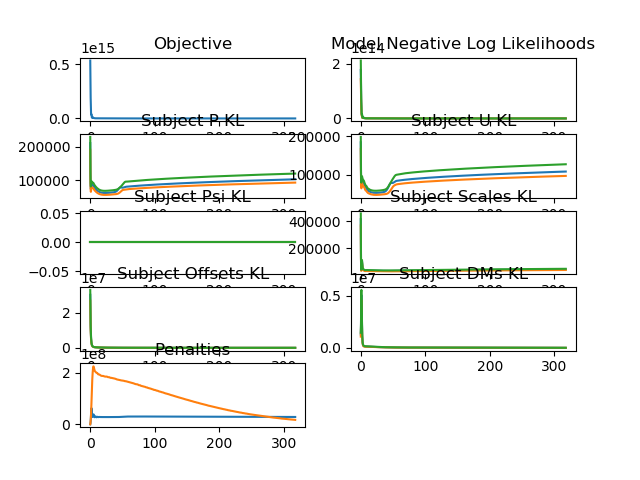

In [172]:
fitter.plot_log(logs0[0])

## Move everything to cpu

In [173]:
fitter.to('cpu')

## Look at predictions the models make on training data

In [143]:
s_preds = [predict_with_truth(s_coll, s_coll.data) for s_coll in vi_collections]

<IPython.core.display.Javascript object>


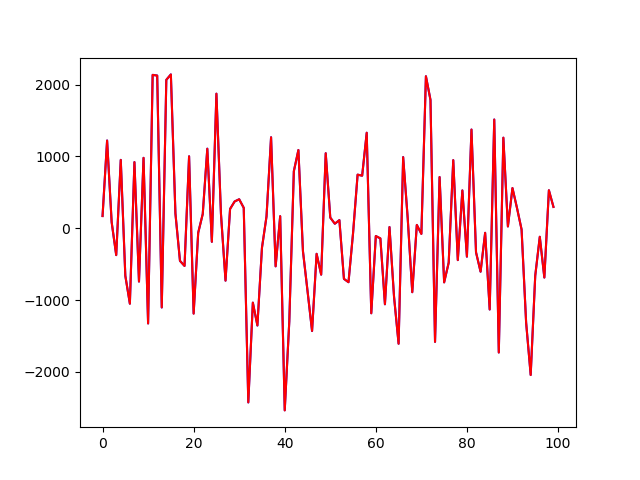

In [144]:
plt_s_i = 2
plot_v_i = 3
smp_inds = slice(0, 100)

plt.figure()
plt.plot(s_preds[plt_s_i]['truth'][0][smp_inds, plot_v_i], 'b-')
plt.plot(s_preds[plt_s_i]['pred'][0][smp_inds, plot_v_i], 'r-')

## Look at true and fit offset and scale distributions

In [176]:
# Offsets
#true_dist = true_offset_dist 
#fit_dist = offsets_prior.dists[0] 

# Scales
true_dist = true_scale_dist
fit_dist = scales_prior.dists[0]

# Direct mapings
#true_dist = true_direct_map_dist
#fit_dist = direct_mappings_prior.dists[0]

<IPython.core.display.Javascript object>


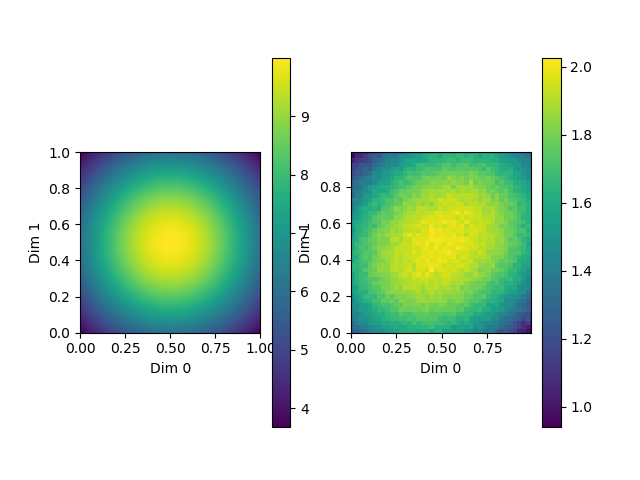

In [177]:
plt.figure()
visualize_2d_function(torch_mod_to_fcn(true_dist.mn_f), ax=plt.subplot(1,2, 1))
#plt.gca().get_images()[0].set_clim(0.0, 10.0)
visualize_2d_function(torch_mod_to_fcn(fit_dist.mn_f), ax=plt.subplot(1,2, 2), 
                      dim_0_range=[0, .99], dim_1_range=[0, .99])
#plt.gca().get_images()[0].set_clim(0.0, 10.0)

## Look at true and fit offset values compared to posteriors on a single neuron basis

In [178]:
vis_s_i = 2
e_shape = [21, 21, 1]

# Offsets
true_vls = true_subj_models[vis_s_i]['mdl'].offsets[0]
fit_dist = vi_collections[vis_s_i].offset_dists[0]

# Scales
true_vls = true_subj_models[vis_s_i]['mdl'].scales[0]
fit_dist = vi_collections[vis_s_i].scale_dists[0]

# Direct mappings
#true_vls = true_subj_models[vis_s_i]['mdl'].direct_mappings[0]
#fit_dist = vi_collections[vis_s_i].direct_mapping_dists[0]

In [179]:
vis_neuron_locs = true_subj_models[vis_s_i]['u_neuron_locs']
vis_true_offsets = true_vls.detach().numpy()
vis_fit_offsets = fit_dist.dists[0](vis_neuron_locs).detach().numpy()
vis_neuron_locs = 1000*np.concatenate([vis_neuron_locs.numpy(), np.zeros([vis_neuron_locs.shape[0], 1])], axis=1)

In [180]:
true_image = generate_dot_image_3d(image_shape=[1001, 1001, 1], dot_ctrs=vis_neuron_locs, 
                                   dot_vls=vis_true_offsets, 
                     ellipse_shape=e_shape) 

fit_image = generate_dot_image_3d(image_shape=[1001, 1001, 1], dot_ctrs=vis_neuron_locs, dot_vls=vis_fit_offsets, 
                     ellipse_shape=e_shape) 

<IPython.core.display.Javascript object>


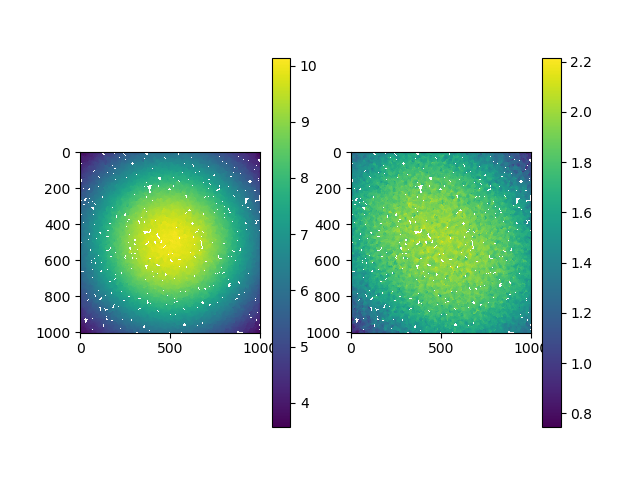

In [181]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.squeeze(true_image))
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.squeeze(fit_image))
plt.colorbar()

## Look at true and estimated distributions over modes

In [182]:
vis_m = 1

#### Learn a transformation to align modes

In [183]:
u_neuron_locs = true_subj_models[0]['u_neuron_locs']
true_u_modes = true_u_dists(u_neuron_locs).detach().cpu().numpy()
est_u_modes = prior_collection.u_dists[0](u_neuron_locs).detach().cpu().numpy()
#est_u_modes = vi_collections[0].u_dists[0](u_neuron_locs).detach().cpu().numpy()
u_neuron_locs = 1000*np.concatenate([u_neuron_locs.numpy(), np.zeros([u_neuron_locs.shape[0], 1])], axis=1)

p_neuron_locs = true_subj_models[0]['p_neuron_locs']
true_p_modes = true_p_dists(p_neuron_locs).detach().cpu().numpy()
#true_p_modes = true_subj_models[0]['mdl'].p[0].detach().cpu().numpy()
est_p_modes = prior_collection.p_dists[0](p_neuron_locs).detach().cpu().numpy()
#est_p_modes = vi_collections[0].p_dists[0](p_neuron_locs).detach().cpu().numpy()
#est_p_modes = vi_collections[0].s_mdl.p[0].detach().cpu().numpy()
p_neuron_locs = 1000*np.concatenate([p_neuron_locs.numpy(), np.zeros([p_neuron_locs.shape[0], 1])], axis=1)

In [184]:
mode_t = np.linalg.lstsq(est_u_modes, true_u_modes, rcond=None)
mode_t = mode_t[0]

In [185]:
est_u_modes_t = np.matmul(est_u_modes, mode_t)
est_p_modes_t = np.matmul(est_p_modes, np.linalg.inv(mode_t))

In [186]:
true_p_modes.shape

(10000, 2)

In [187]:
e_shape = [21, 21, 1]

true_u_image = generate_dot_image_3d(image_shape=[1001, 1001, 1], dot_ctrs=u_neuron_locs, 
                                   dot_vls=true_u_modes[:,vis_m], 
                                   ellipse_shape=e_shape) 

fit_u_image = generate_dot_image_3d(image_shape=[1001, 1001, 1], dot_ctrs=u_neuron_locs, 
                                  dot_vls=est_u_modes_t[:,vis_m], 
                                   ellipse_shape=e_shape) 

true_p_image = generate_dot_image_3d(image_shape=[1002, 1002, 1], dot_ctrs=p_neuron_locs, 
                                   dot_vls=true_p_modes[:,vis_m], 
                                   ellipse_shape=e_shape) 

fit_p_image = generate_dot_image_3d(image_shape=[1002, 1002, 1], dot_ctrs=p_neuron_locs, 
                                  dot_vls=est_p_modes[:,vis_m], 
                                  ellipse_shape=e_shape) 

<IPython.core.display.Javascript object>


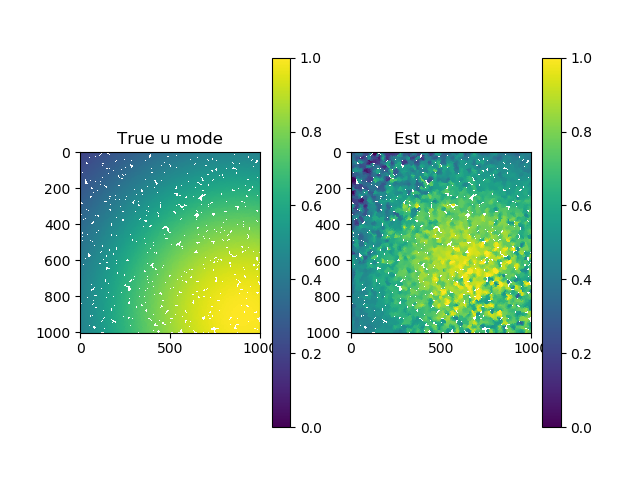

<IPython.core.display.Javascript object>


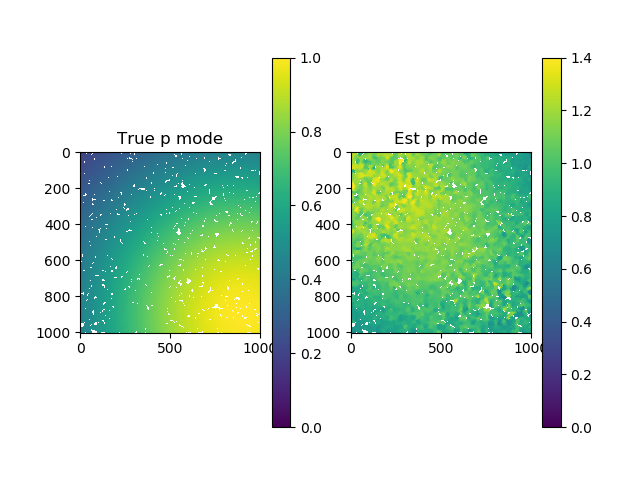

In [188]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.squeeze(true_u_image), clim=[0, 1])
plt.colorbar()
plt.title('True u mode')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(fit_u_image), clim=[0, 1])
plt.title('Est u mode')
plt.colorbar()

plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.squeeze(true_p_image), clim=[0, 1])
plt.colorbar()
plt.title('True p mode')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(fit_p_image), clim=[0, 1.4])
plt.title('Est p mode')
plt.colorbar()
